# Projet Groupe détection de posture de yoga #

## 1/ import des differentes library ##

Mediapipe, numpy, matplotlib, openCV

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os

## différentes fonctions de mediapipe
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.python.solutions.pose import PoseLandmark


## 2/ création des différentes fonctions

Cela va nous permettre de lire une image, afficher les informations nécessaires, et de dessiner les lankmarkes dessus

In [2]:
# fonction qui permet de dessiner les landmarks sur l'image

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image



In [3]:
# fonction qui permet d'afficher une image avec matplotlib
def display_image(image, convert_bgr_to_rgb=False, title=None):
    """ Display the image using matplotlib

    Arguments:
        image (np.ndarray): the image to display
        convert_bgr_to_rgb (bool)[Optional]: Set this to True when image comes from OpenCV imread
        title (str)[Optional]: Title displayed above the image
    """
    # conversion from BGR to RGB if needed
    if convert_bgr_to_rgb:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    plt.imshow(image,interpolation='nearest')
    plt.axis('on') 
    
    if title is not None:
        plt.title(title)
        
    plt.show()    

# fonction qui permet de afficher des informations basiques sur une image
def image_info(image):
    """ Display basic information about an image
    
    Arguments:
        image (np.ndarray): the image to analyze
    """
    print('Image type:', type(image))
    print('Image data type:', image.dtype)
    print('Image shape:', image.shape)
    print('Min value:', image.min())
    # returns the smallest pixel value across all pixels in the image
    #For color images (e.g., RGB), the function operates on the entire array, returning a single minimum value across all channels and all pixels.
    print('Max value:', image.max()) 
    #  returns the maximum pixel intensity value across all dimensions of the image, including width, height, and color channels
    

In [33]:
def process_pose_image(
    img_path: str,
    detector,
    draw_landmarks_on_image,
    display_image,
    show_landmarks: bool = True,
    show_mask: bool = True,
    print_landmarks: bool = True,
):
    """
    Traite une image pour pose landmarks + (optionnel) segmentation mask + (optionnel) print coords.

    Returns
    -------
    result : PoseLandmarkerResult
    annotated : np.ndarray (RGB)
    mask_uint8 : np.ndarray (H,W,3) uint8 ou None
    """
    

    # 1) Load as mp.Image
    mp_image = mp.Image.create_from_file(img_path)

    # 2) Detect
    result = detector.detect(mp_image)

    # 3) Base image (RGB)
    img_rgb = mp_image.numpy_view()
    h, w = img_rgb.shape[:2]

    # 4) Annotated landmarks
    annotated = None
    if show_landmarks:
        annotated = draw_landmarks_on_image(img_rgb, result)
        display_image(annotated, title="Pose Landmarks")

    # 5) Segmentation mask (if available)
    mask_uint8 = None
    if show_mask and getattr(result, "segmentation_masks", None):
        if len(result.segmentation_masks) > 0:
            mask = result.segmentation_masks[0].numpy_view()  # (H,W) float
            mask_uint8 = (np.repeat(mask[:, :, None], 3, axis=2) * 255).astype(np.uint8)
            display_image(mask_uint8, title="Segmentation Mask")

    # 6) Print landmark coords (if available)
    if print_landmarks and result.pose_landmarks and len(result.pose_landmarks) > 0:
        lms = result.pose_landmarks[0]
        for i, lm in enumerate(lms):
            print(
                f"LM[{i:02d}]  x={lm.x:.4f} y={lm.y:.4f}  ->  ({int(lm.x*w)}, {int(lm.y*h)})  vis={lm.visibility:.3f}"
                )
    elif print_landmarks:
        print("Aucun pose_landmarks détecté sur cette image.")

    return result, annotated, mask_uint8

## 3/ téléchargement des images de pose Cobra

Image type: <class 'numpy.ndarray'>
Image data type: uint8
Image shape: (147, 215, 3)
Min value: 6
Max value: 254


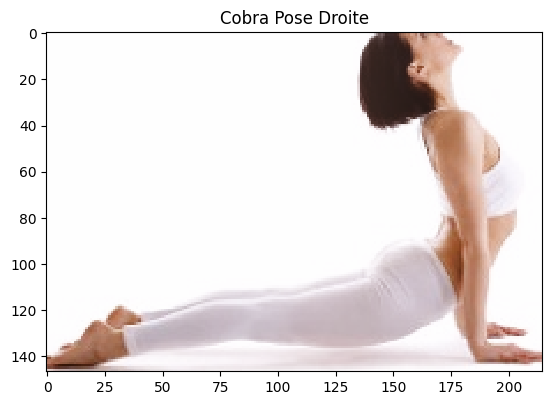

In [10]:
CobraDroite = cv2.imread('../Posture_yoga/Cobra_final/File49.png')
image_info(CobraDroite)
display_image(CobraDroite, convert_bgr_to_rgb=True, title='Cobra Pose Droite')

Image type: <class 'numpy.ndarray'>
Image data type: uint8
Image shape: (425, 605, 3)
Min value: 0
Max value: 255


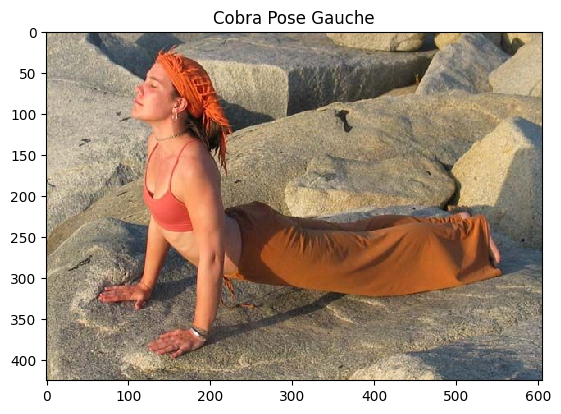

In [11]:
CobraGauche = cv2.imread('../Posture_yoga/Cobra_final/3_280.jpg')
image_info(CobraGauche)
display_image(CobraGauche, convert_bgr_to_rgb=True, title='Cobra Pose Gauche')

Image type: <class 'numpy.ndarray'>
Image data type: uint8
Image shape: (4080, 3072, 3)
Min value: 0
Max value: 255


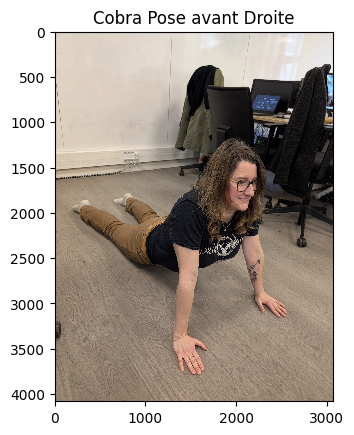

In [12]:
CobraAvtDroit = cv2.imread('../Posture_yoga/Cobra_final/PXL_20251217_103740979.MP.jpg')
image_info(CobraAvtDroit)
display_image(CobraAvtDroit, convert_bgr_to_rgb=True, title='Cobra Pose avant Droite')

Image type: <class 'numpy.ndarray'>
Image data type: uint8
Image shape: (3072, 4080, 3)
Min value: 0
Max value: 255


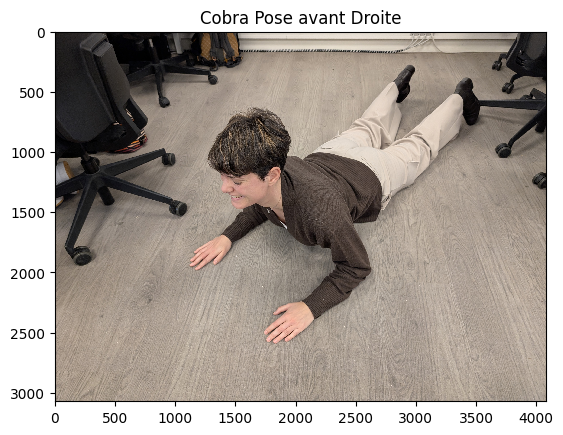

In [13]:
CobraAvtGauche = cv2.imread('../Posture_yoga/Cobra_final/PXL_20251217_103555587.MP.jpg')
image_info(CobraAvtGauche)
display_image(CobraAvtGauche, convert_bgr_to_rgb=True, title='Cobra Pose avant Droite')

## 4/ Déctection des landmarks sur les photos

In [ ]:
# Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker_lite.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

### 4.1. Pose Cobra Avant Gauche 

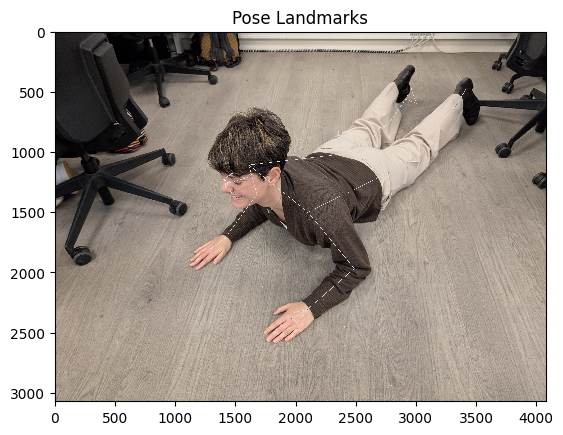

In [ ]:
imageAvtGauche = mp.Image.create_from_file('../Posture_yoga/Cobra_final/PXL_20251217_103555587.MP.jpg')
resultAvtGauche = detector.detect(imageAvtGauche)
resultAvtGauche.pose_landmarks

#Process the detection result. In this case, visualize it.
annotatedAvtGauche= draw_landmarks_on_image(imageAvtGauche.numpy_view(),resultAvtGauche)
display_image(annotatedAvtGauche, title='Pose Landmarks')

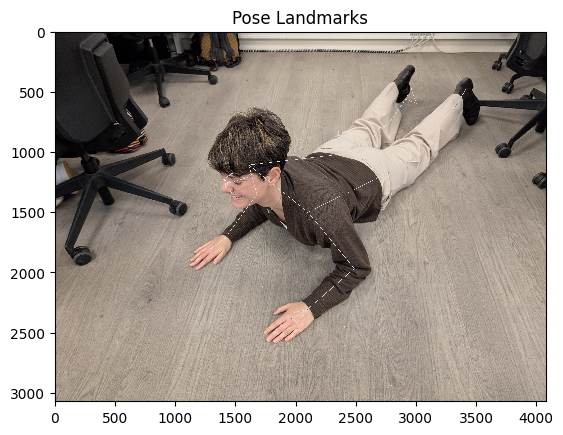

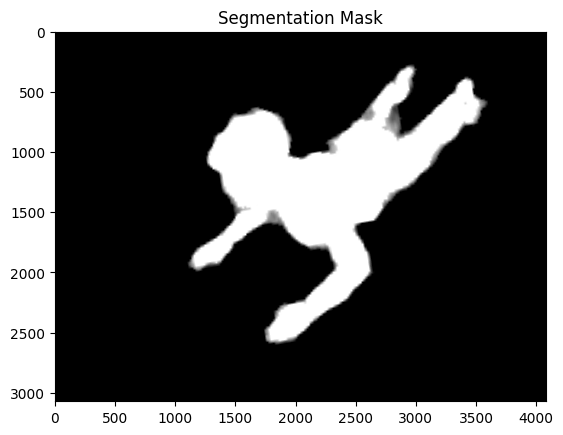

LM[00]  x=0.3482 y=0.4297  ->  (1420, 1319)  vis=1.000
LM[01]  x=0.3521 y=0.4101  ->  (1436, 1259)  vis=1.000
LM[02]  x=0.3581 y=0.4086  ->  (1461, 1255)  vis=1.000
LM[03]  x=0.3635 y=0.4074  ->  (1482, 1251)  vis=1.000
LM[04]  x=0.3464 y=0.4048  ->  (1413, 1243)  vis=1.000
LM[05]  x=0.3440 y=0.4028  ->  (1403, 1237)  vis=1.000
LM[06]  x=0.3443 y=0.4005  ->  (1404, 1230)  vis=1.000
LM[07]  x=0.3979 y=0.3933  ->  (1623, 1208)  vis=1.000
LM[08]  x=0.3603 y=0.3855  ->  (1470, 1184)  vis=1.000
LM[09]  x=0.3663 y=0.4393  ->  (1494, 1349)  vis=1.000
LM[10]  x=0.3570 y=0.4347  ->  (1456, 1335)  vis=1.000
LM[11]  x=0.5150 y=0.4896  ->  (2101, 1503)  vis=1.000
LM[12]  x=0.3948 y=0.3621  ->  (1610, 1112)  vis=0.999
LM[13]  x=0.6098 y=0.6420  ->  (2487, 1972)  vis=0.994
LM[14]  x=0.4113 y=0.4409  ->  (1678, 1354)  vis=0.168
LM[15]  x=0.5139 y=0.7528  ->  (2096, 2312)  vis=0.971
LM[16]  x=0.3466 y=0.5596  ->  (1414, 1718)  vis=0.266
LM[17]  x=0.4928 y=0.7871  ->  (2010, 2418)  vis=0.944
LM[18]  x=

In [27]:
result, annotated, mask = process_pose_image(
    "../Posture_yoga/Cobra_final/PXL_20251217_103555587.MP.jpg",
    detector=detector,
    draw_landmarks_on_image=draw_landmarks_on_image,
    display_image=display_image,
    show_landmarks=True,
    show_mask=True,
    print_landmarks=True,
)


Images choisies :
 - ../Posture_yoga/Cobra_final\File35.png
 - ../Posture_yoga/Cobra_final\PXL_20251217_103740979.MP.jpg
 - ../Posture_yoga/Cobra_final\File33.png
 - ../Posture_yoga/Cobra_final\3_280.jpg
 - ../Posture_yoga/Cobra_final\PXL_20251217_103539703.MP.jpg

Processing: ../Posture_yoga/Cobra_final\File35.png


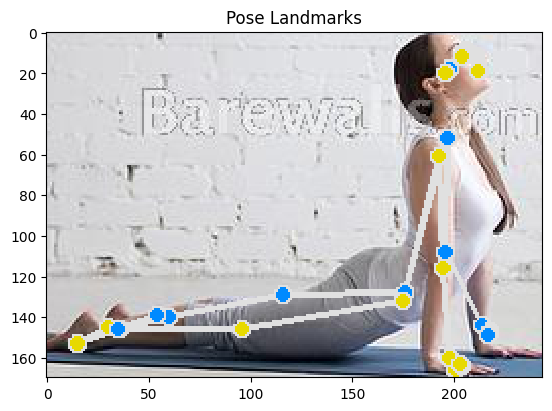

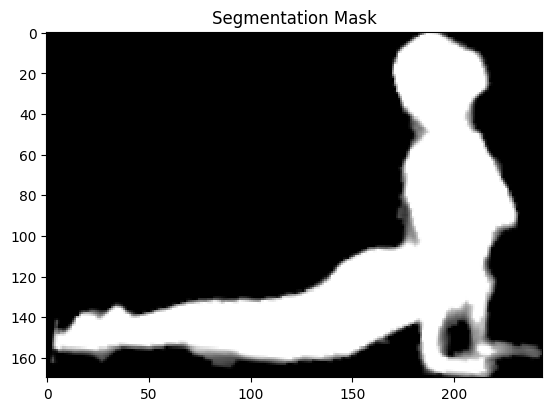

LM[00]  x=0.8667 y=0.0741  ->  (211, 12)  vis=0.995
LM[01]  x=0.8474 y=0.0569  ->  (206, 9)  vis=0.989
LM[02]  x=0.8454 y=0.0584  ->  (206, 9)  vis=0.990
LM[03]  x=0.8424 y=0.0612  ->  (205, 10)  vis=0.993
LM[04]  x=0.8459 y=0.0623  ->  (206, 10)  vis=0.996
LM[05]  x=0.8427 y=0.0667  ->  (205, 11)  vis=0.997
LM[06]  x=0.8381 y=0.0720  ->  (204, 12)  vis=0.996
LM[07]  x=0.8138 y=0.1059  ->  (198, 18)  vis=0.989
LM[08]  x=0.8068 y=0.1218  ->  (196, 20)  vis=0.997
LM[09]  x=0.8746 y=0.1142  ->  (213, 19)  vis=0.995
LM[10]  x=0.8718 y=0.1168  ->  (212, 19)  vis=0.995
LM[11]  x=0.8106 y=0.3078  ->  (197, 52)  vis=0.998
LM[12]  x=0.7948 y=0.3619  ->  (193, 61)  vis=0.999
LM[13]  x=0.8069 y=0.6400  ->  (196, 108)  vis=0.150
LM[14]  x=0.8009 y=0.6829  ->  (195, 116)  vis=0.980
LM[15]  x=0.8784 y=0.8480  ->  (214, 144)  vis=0.317
LM[16]  x=0.8129 y=0.9467  ->  (198, 160)  vis=0.955
LM[17]  x=0.8954 y=0.8696  ->  (218, 147)  vis=0.336
LM[18]  x=0.8267 y=0.9796  ->  (201, 166)  vis=0.917
LM[19]  

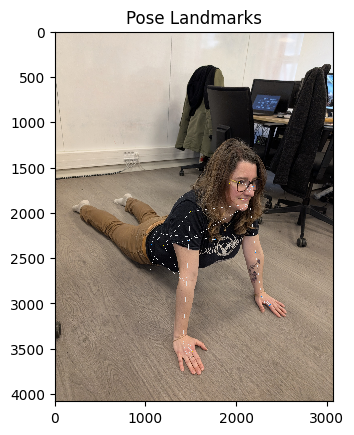

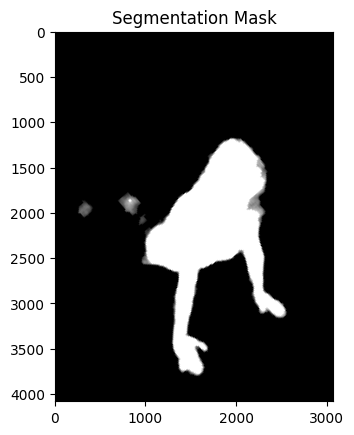

LM[00]  x=0.6948 y=0.4376  ->  (2134, 1785)  vis=1.000
LM[01]  x=0.7056 y=0.4197  ->  (2167, 1712)  vis=1.000
LM[02]  x=0.7110 y=0.4203  ->  (2184, 1714)  vis=1.000
LM[03]  x=0.7166 y=0.4212  ->  (2201, 1718)  vis=1.000
LM[04]  x=0.6834 y=0.4138  ->  (2099, 1688)  vis=1.000
LM[05]  x=0.6740 y=0.4125  ->  (2070, 1683)  vis=1.000
LM[06]  x=0.6606 y=0.4096  ->  (2029, 1671)  vis=1.000
LM[07]  x=0.7088 y=0.4189  ->  (2177, 1708)  vis=1.000
LM[08]  x=0.6253 y=0.4118  ->  (1921, 1680)  vis=1.000
LM[09]  x=0.6919 y=0.4569  ->  (2125, 1864)  vis=1.000
LM[10]  x=0.6687 y=0.4551  ->  (2054, 1856)  vis=1.000
LM[11]  x=0.6987 y=0.4677  ->  (2146, 1908)  vis=1.000
LM[12]  x=0.4850 y=0.4879  ->  (1490, 1990)  vis=1.000
LM[13]  x=0.7193 y=0.5983  ->  (2209, 2440)  vis=0.947
LM[14]  x=0.4726 y=0.6661  ->  (1451, 2717)  vis=0.993
LM[15]  x=0.7397 y=0.7169  ->  (2272, 2925)  vis=0.975
LM[16]  x=0.4584 y=0.8381  ->  (1408, 3419)  vis=0.994
LM[17]  x=0.7723 y=0.7385  ->  (2372, 3013)  vis=0.960
LM[18]  x=

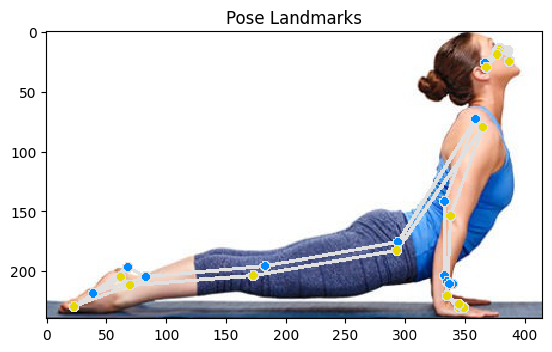

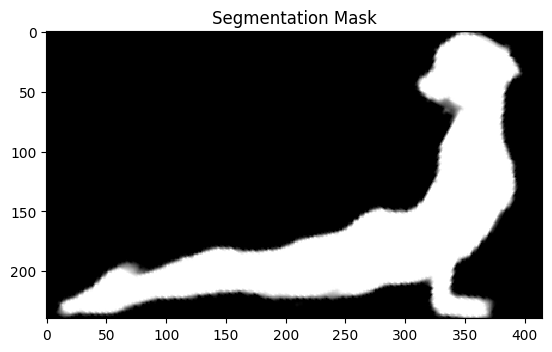

LM[00]  x=0.9311 y=0.0671  ->  (386, 16)  vis=0.999
LM[01]  x=0.9145 y=0.0612  ->  (379, 14)  vis=0.998
LM[02]  x=0.9122 y=0.0643  ->  (378, 15)  vis=0.999
LM[03]  x=0.9094 y=0.0682  ->  (377, 16)  vis=0.999
LM[04]  x=0.9141 y=0.0666  ->  (379, 15)  vis=0.999
LM[05]  x=0.9115 y=0.0730  ->  (378, 17)  vis=1.000
LM[06]  x=0.9087 y=0.0792  ->  (377, 19)  vis=0.999
LM[07]  x=0.8861 y=0.1109  ->  (367, 26)  vis=0.999
LM[08]  x=0.8885 y=0.1257  ->  (368, 30)  vis=1.000
LM[09]  x=0.9335 y=0.1013  ->  (387, 24)  vis=0.998
LM[10]  x=0.9337 y=0.1065  ->  (387, 25)  vis=0.998
LM[11]  x=0.8660 y=0.3069  ->  (359, 73)  vis=0.998
LM[12]  x=0.8797 y=0.3354  ->  (365, 80)  vis=1.000
LM[13]  x=0.8038 y=0.5957  ->  (333, 142)  vis=0.045
LM[14]  x=0.8167 y=0.6425  ->  (338, 154)  vis=0.986
LM[15]  x=0.8037 y=0.8501  ->  (333, 204)  vis=0.093
LM[16]  x=0.8082 y=0.9237  ->  (335, 221)  vis=0.893
LM[17]  x=0.8089 y=0.8712  ->  (335, 209)  vis=0.116
LM[18]  x=0.8317 y=0.9639  ->  (345, 231)  vis=0.813
LM[19]

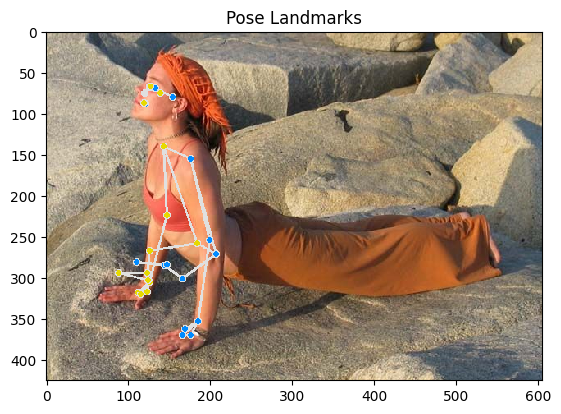

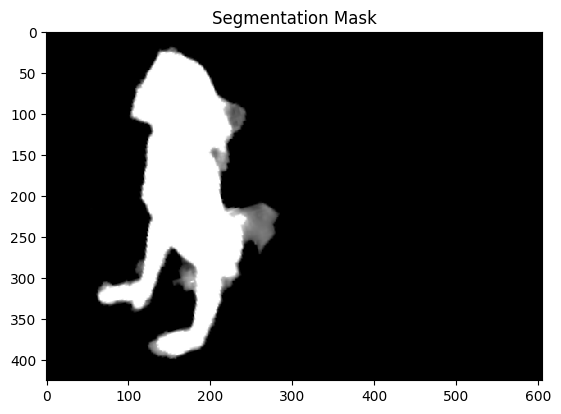

LM[00]  x=0.1995 y=0.1785  ->  (120, 75)  vis=1.000
LM[01]  x=0.2124 y=0.1611  ->  (128, 68)  vis=1.000
LM[02]  x=0.2168 y=0.1618  ->  (131, 68)  vis=1.000
LM[03]  x=0.2214 y=0.1638  ->  (133, 69)  vis=1.000
LM[04]  x=0.2087 y=0.1596  ->  (126, 67)  vis=1.000
LM[05]  x=0.2094 y=0.1594  ->  (126, 67)  vis=1.000
LM[06]  x=0.2102 y=0.1595  ->  (127, 67)  vis=1.000
LM[07]  x=0.2550 y=0.1901  ->  (154, 80)  vis=1.000
LM[08]  x=0.2308 y=0.1783  ->  (139, 75)  vis=1.000
LM[09]  x=0.2016 y=0.2076  ->  (121, 88)  vis=1.000
LM[10]  x=0.1976 y=0.2055  ->  (119, 87)  vis=1.000
LM[11]  x=0.2917 y=0.3648  ->  (176, 155)  vis=1.000
LM[12]  x=0.2380 y=0.3305  ->  (143, 140)  vis=1.000
LM[13]  x=0.3304 y=0.5998  ->  (199, 254)  vis=0.952
LM[14]  x=0.2435 y=0.5293  ->  (147, 224)  vis=0.092
LM[15]  x=0.3066 y=0.8326  ->  (185, 353)  vis=0.913
LM[16]  x=0.2092 y=0.7193  ->  (126, 305)  vis=0.200
LM[17]  x=0.2913 y=0.8729  ->  (176, 370)  vis=0.843
LM[18]  x=0.1858 y=0.7483  ->  (112, 318)  vis=0.196
LM[1

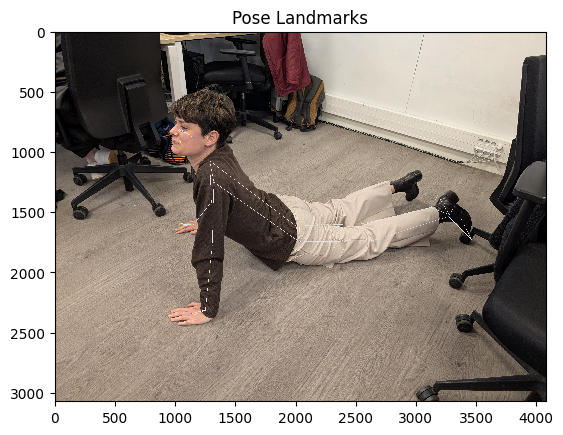

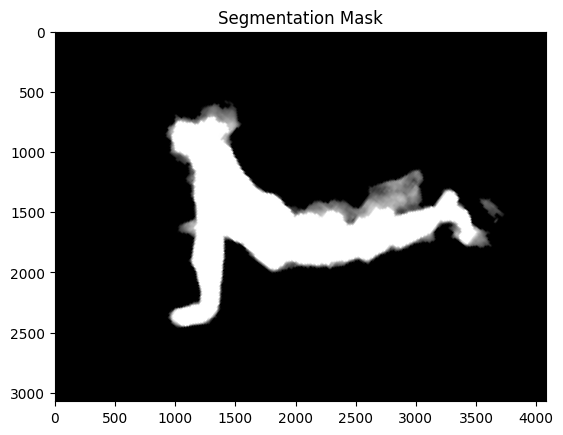

LM[00]  x=0.2452 y=0.2802  ->  (1000, 860)  vis=1.000
LM[01]  x=0.2547 y=0.2696  ->  (1039, 828)  vis=1.000
LM[02]  x=0.2572 y=0.2709  ->  (1049, 832)  vis=1.000
LM[03]  x=0.2609 y=0.2716  ->  (1064, 834)  vis=1.000
LM[04]  x=0.2531 y=0.2675  ->  (1032, 821)  vis=1.000
LM[05]  x=0.2548 y=0.2674  ->  (1039, 821)  vis=1.000
LM[06]  x=0.2568 y=0.2674  ->  (1047, 821)  vis=1.000
LM[07]  x=0.2815 y=0.2875  ->  (1148, 883)  vis=1.000
LM[08]  x=0.2738 y=0.2798  ->  (1117, 859)  vis=1.000
LM[09]  x=0.2558 y=0.3000  ->  (1043, 921)  vis=1.000
LM[10]  x=0.2535 y=0.2968  ->  (1034, 911)  vis=1.000
LM[11]  x=0.3236 y=0.4083  ->  (1320, 1254)  vis=1.000
LM[12]  x=0.3154 y=0.3510  ->  (1286, 1078)  vis=1.000
LM[13]  x=0.3201 y=0.5803  ->  (1306, 1782)  vis=0.997
LM[14]  x=0.3186 y=0.4623  ->  (1299, 1420)  vis=0.155
LM[15]  x=0.3062 y=0.7542  ->  (1249, 2316)  vis=0.982
LM[16]  x=0.2814 y=0.5241  ->  (1147, 1610)  vis=0.336
LM[17]  x=0.2855 y=0.7667  ->  (1164, 2355)  vis=0.954
LM[18]  x=0.2539 y=0.

In [34]:
import os
import random

# 1) Récupérer toutes les images du dossier
folder = "../Posture_yoga/Cobra_final"
exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

all_imgs = [
    os.path.join(folder, f)
    for f in os.listdir(folder)
    if f.lower().endswith(exts)
]

# 2) En prendre 5 au hasard (ou moins si le dossier en a < 5)
k = min(5, len(all_imgs))
sample_paths = random.sample(all_imgs, k)

print("Images choisies :")
for p in sample_paths:
    print(" -", p)

# 3) Faire tourner ta fonction sur ces 5 images
for p in sample_paths:
    print("\n==============================")
    print("Processing:", p)
    result, annotated, mask = process_pose_image(
        p,
        detector=detector,
        draw_landmarks_on_image=draw_landmarks_on_image,
        display_image=display_image,
        show_landmarks=True,
        show_mask=True,
        print_landmarks=True,   # mets True si tu veux spammer les coords
    )